In [52]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
import itertools
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline

In [2]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

In [3]:
# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [4]:
# Define a function to extract features from a list of images
# This function assumes images in list are RGB readed by cv2 as BGR
def extract_features(imgs, cspace='BGR', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256)):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one. Us cv2 for consistency
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'BGR':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
        else: feature_image = np.copy(image)      
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features)))
    # Return list of feature vectors
    return features

In [5]:
# Read in car and no car images
car_images = glob.glob('./image_set/vehicles/*.png')
no_car_images = glob.glob('./image_set/non-vehicles/*.png')
cars = []
notcars = []

for image in car_images:
    cars.append(image)
for image in no_car_images:
    notcars.append(image)

In [6]:
# To optimize the performance of this classifier we need to change integer variables
# That is a integer programming problem which is not at all trivial, it is NP hard generally.
# A brute force approach that does not uses specialized libreries is to explore the design space as a grid
# I define a first coarse grid to analyze with n divisions
n = 4
spatial_grid = np.linspace(8, 32, n).astype(int)
histbin_grid = np.linspace(8, 32, n).astype(int)
colors = ['BGR', 'HSV', 'LUV', 'HLS', 'YUV']

In [7]:
# We need to do on fitting of the model for each point. Since we are taking random samples for test and train
# every point would be tested in a slightly different dataset. To account for that, ideally we would like to
# run each evaluation several times and calculate an average. Since we are using this to compare meta parameters
# and in order to avoid taken too much time we would evaluate with a constant train and testing sets.
# Let's define a utility function for the model
def svm_car_classifier(cars, notcars, spatial=32, histbin=32, cspace='BGR', seed=np.random.randint(0, 100)):
    ''' Takes in a list of files representing car and no car images together with parametes for
    feature straction. Returns the fitted model and its score
    '''
    car_features = extract_features(cars, cspace='BGR', spatial_size=(spatial, spatial),
                                    hist_bins=histbin, hist_range=(0, 256))
    notcar_features = extract_features(notcars, cspace='BGR', spatial_size=(spatial, spatial),
                                    hist_bins=histbin, hist_range=(0, 256))

    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)

    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

    print('Trainning model with binning of:',spatial, 'and',
          histbin,'histogram bins, color', c, 'Features:', len(X_train[0]))
    # Use a linear SVC 
    svc = LinearSVC()
    svc.fit(X_train, y_train)
    # Check the score of the SVC
    score = svc.score(X_test, y_test)
    print('Test Accuracy of SVC = ', round(score, 4))
    return svc, score

In [8]:
x_plot = []
y_plot = []
performance = []
models = []
for c, s, h in itertools.product(colors, spatial_grid, histbin_grid):
    x_plot.append(s)
    y_plot.append(h)
    # Call the classifier with a constant seed
    m, p = svm_car_classifier(cars, notcars, spatial=s, histbin=h, cspace=c, seed= 3)
    models.append(m)
    performance.append(p)

Trainning model with binning of: 8 and 8 histogram bins, color BGR Features: 216
Test Accuracy of SVC =  0.9107
Trainning model with binning of: 8 and 16 histogram bins, color BGR Features: 240
Test Accuracy of SVC =  0.9089
Trainning model with binning of: 8 and 24 histogram bins, color BGR Features: 264
Test Accuracy of SVC =  0.9161
Trainning model with binning of: 8 and 32 histogram bins, color BGR Features: 288
Test Accuracy of SVC =  0.9123
Trainning model with binning of: 16 and 8 histogram bins, color BGR Features: 792
Test Accuracy of SVC =  0.9283
Trainning model with binning of: 16 and 16 histogram bins, color BGR Features: 816
Test Accuracy of SVC =  0.9334
Trainning model with binning of: 16 and 24 histogram bins, color BGR Features: 840
Test Accuracy of SVC =  0.9101
Trainning model with binning of: 16 and 32 histogram bins, color BGR Features: 864
Test Accuracy of SVC =  0.9296
Trainning model with binning of: 24 and 8 histogram bins, color BGR Features: 1752
Test Accura

In [24]:
import pickle
for model, (c, s, h) in zip(models, itertools.product(colors, spatial_grid, histbin_grid)):
    print('Saving to disk fitted model for color channels:',c, 'spatial binning', s,'and histogram binning', h)
    file_name = '-'.join((c, 's_bin_{:d}'.format(s), 'h_bin_{:d}'.format(h)))
    file_name = '.'.join((file_name, 'pickle'))
    pickle.dump(model, open('./svm/' + file_name, 'wb'))

Saving to disk fitted model for color channels: BGR spatial binning 8 and histogram binning 8
Saving to disk fitted model for color channels: BGR spatial binning 8 and histogram binning 16
Saving to disk fitted model for color channels: BGR spatial binning 8 and histogram binning 24
Saving to disk fitted model for color channels: BGR spatial binning 8 and histogram binning 32
Saving to disk fitted model for color channels: BGR spatial binning 16 and histogram binning 8
Saving to disk fitted model for color channels: BGR spatial binning 16 and histogram binning 16
Saving to disk fitted model for color channels: BGR spatial binning 16 and histogram binning 24
Saving to disk fitted model for color channels: BGR spatial binning 16 and histogram binning 32
Saving to disk fitted model for color channels: BGR spatial binning 24 and histogram binning 8
Saving to disk fitted model for color channels: BGR spatial binning 24 and histogram binning 16
Saving to disk fitted model for color channels:

In [85]:
BGR_perf = np.array(performance[0:16])
HSV_perf = np.array(performance[16:32])
LUV_perf = np.array(performance[32:48])
HLS_perf = np.array(performance[48:64])
YUV_perf = np.array(performance[64:80])

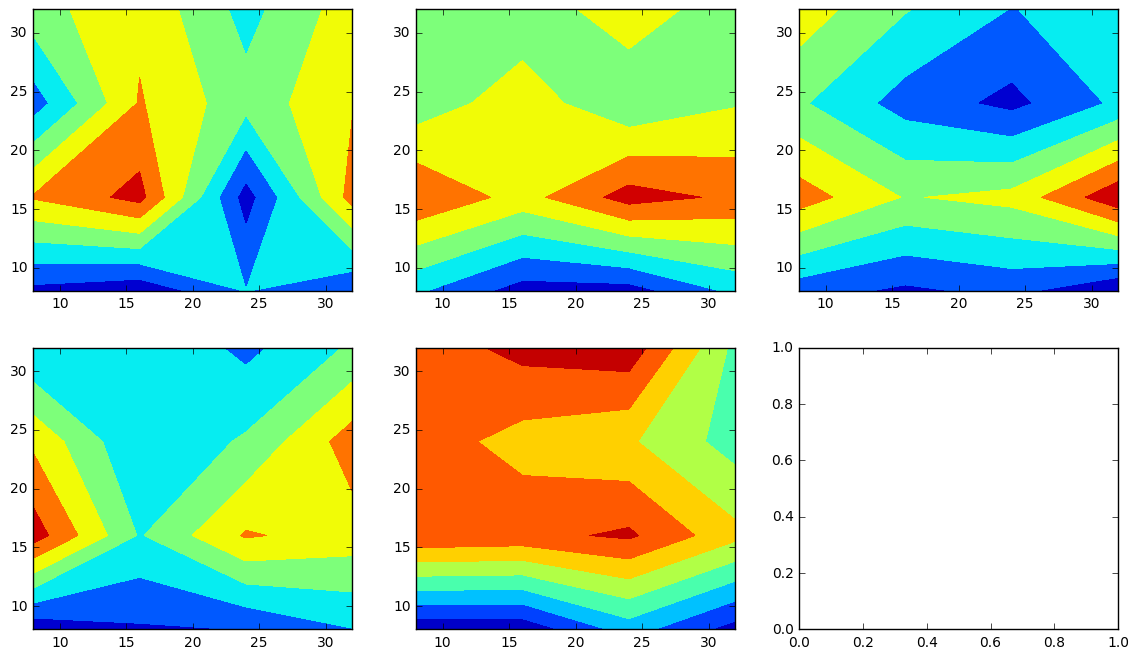

In [86]:
fig, ax = plt.subplots(2,3)
ax[0,0].contourf(spatial_grid, histbin_grid, BGR_perf.reshape(n, n))
ax[0,1].contourf(spatial_grid, histbin_grid, HSV_perf.reshape(n, n))
ax[0,2].contourf(spatial_grid, histbin_grid, LUV_perf.reshape(n, n))
ax[1,0].contourf(spatial_grid, histbin_grid, HLS_perf.reshape(n, n))
ax[1,1].contourf(spatial_grid, histbin_grid, YUV_perf.reshape(n, n))
fig.set_size_inches(14,8)

In [87]:
best_perf = np.array(performance).argmax()
best_s = x_plot[best_perf]
best_h = y_plot[best_perf]
best_color = colors[int(best_perf / (n * n))]
print('Best performace', round(max(performance),3), 'is obtained using spatial binning of',
      best_s, 'and histogram binning of', best_h, 'in a', best_color, 'colorspace')

Best performace 0.939 is obtained using spatial binning of 16 and histogram binning of 32 in a LUV colorspace
